In [6]:
!pip install pydub ffmpeg joblib librosa numpy


Loading cached MFCCs...
Feature Extraction Completed! Dataset Size: (30000, 10, 100)
Training LinearSVC...
LinearSVC Accuracy: 0.8220
              precision    recall  f1-score   support

     Bengali       0.77      0.78      0.77      2000
       Hindi       0.80      0.80      0.80      2000
       Tamil       0.91      0.88      0.89      2000

    accuracy                           0.82      6000
   macro avg       0.82      0.82      0.82      6000
weighted avg       0.82      0.82      0.82      6000



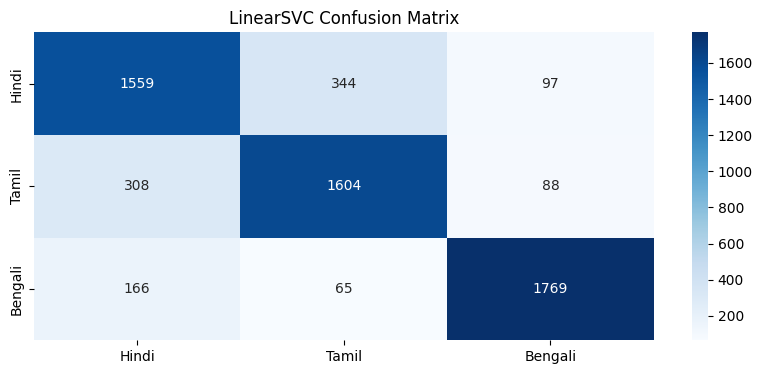

In [7]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa.display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from joblib import Parallel, delayed, dump, load

# Settings
n_mfcc = 10
max_pad_len = 100
max_samples_per_class = 10000  # You can adjust this
mfcc_cache_path = "mfcc_data.joblib"

# Fast MFCC extraction (expecting .wav — update if still using .mp3)
def extract_mfcc(file_path, n_mfcc=n_mfcc, max_pad_len=max_pad_len):
    try:
        y, sr = librosa.load(file_path, sr=None)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

        if mfccs.shape[1] < max_pad_len:
            mfccs = np.pad(mfccs, ((0, 0), (0, max_pad_len - mfccs.shape[1])), mode='constant')
        else:
            mfccs = mfccs[:, :max_pad_len]

        return mfccs
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

def process_audio_folder(folder_path, label, n_mfcc=n_mfcc, max_samples=max_samples_per_class):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".mp3")]
    all_files = all_files[:max_samples]

    print(f"Processing {len(all_files)} files for {label}...")
    results = Parallel(n_jobs=8)(delayed(extract_mfcc)(f) for f in all_files)
    results = [mfcc for mfcc in results if mfcc is not None]
    labels = [label] * len(results)

    return results, labels

audio_dirs = {
    "Hindi": "/kaggle/input/audio-dataset-with-10-indian-languages/Language Detection Dataset/Hindi",
    "Tamil": "/kaggle/input/audio-dataset-with-10-indian-languages/Language Detection Dataset/Tamil",
    "Bengali": "/kaggle/input/audio-dataset-with-10-indian-languages/Language Detection Dataset/Bengali"
}

# Load or compute MFCCs
if os.path.exists(mfcc_cache_path):
    print("Loading cached MFCCs...")
    mfcc_data, labels = load(mfcc_cache_path)
else:
    mfcc_data = []
    labels = []
    for language, folder_path in audio_dirs.items():
        mfccs, lang_labels = process_audio_folder(folder_path, language)
        mfcc_data.extend(mfccs)
        labels.extend(lang_labels)
    dump((mfcc_data, labels), mfcc_cache_path)

# Convert to NumPy arrays
X = np.array(mfcc_data)
y = np.array(labels)

print(f"Feature Extraction Completed! Dataset Size: {X.shape}")

# Flatten MFCCs
X_flat = X.reshape(X.shape[0], -1)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, stratify=y, random_state=42)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Fast LinearSVC
print("Training LinearSVC...")
svm = LinearSVC(dual=False, max_iter=10000)
svm.fit(X_train_scaled, y_train)
y_pred = svm.predict(X_test_scaled)

# Evaluation
print(f"LinearSVC Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(10, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues",
            xticklabels=audio_dirs.keys(), yticklabels=audio_dirs.keys())
plt.title("LinearSVC Confusion Matrix")
plt.show()
